In [3]:
import os
import theano
from theano import *
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
from argparse import Namespace
import argparse
import pickle
import json
import math
import resource
import traceback

# Set maximum number of open files
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
print(hard)

200000


# Define parameters

In [5]:
# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0])
if not rd.endswith('fibe2-mini-project'):
    rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0],'fibe2-mini-project')

In [7]:
with open(os.path.join(rd,'data','output',"posterior_samples/linear_reservoir_samples_priors.json"), 'r') as f:
    params = json.load(f)

params['nsamples'] = 100
params['nchains'] = 1

with open(os.path.join(rd,'data','output',"simulations/linear_reservoir_simulation_small_true_parameters.json"), 'r') as f:
    true_params = json.load(f)

# Convert dict to namespace
args = Namespace(**params)
true_args = Namespace(**true_params)


print(json.dumps(params, indent=2))

{
  "input_filename": "simulations/linear_reservoir_simulation.csv",
  "output_filename": "posterior_samples/linear_reservoir_samples.pickle",
  "kmax": 10.0,
  "alpha": 2.0,
  "beta": 40.0,
  "nsamples": 100,
  "nchains": 1,
  "randomseed": 24
}


In [8]:
class LinearReservoirModel(object):

    def __init__(self, net_rainfall_data, parameters):
            self._q0 = np.array([parameters.q0], dtype=np.float64)
            self._times = range(0,len(net_rainfall_data))
            self._nrint = interp1d(self._times, net_rainfall_data,fill_value="extrapolate",kind='slinear')
            self._n_times = len(net_rainfall_data)
            self._n_states = 1
            
    def _simulate(self, parameters, times):
        k = float(parameters[0])

        def rhs(y, t, p):
            return (max(self._nrint(t),0.0001) - y) * (1./k)
#             return (self._nrint(t) - y) * (1./k)

        values = odeint(rhs, self._q0, self._times, (parameters,),rtol=1e-6,atol=1e-6)
        nonzero_values = np.array([[max(0.0001,qsim[0])] for qsim in values]).reshape(values.shape[0],1)

#         return values
        return nonzero_values

    def simulate(self, x):
        return self._simulate(x, self._times)

# Import data

In [32]:
ndata = 20 # max 199

In [35]:
# Import simulated data from all three models
model0data = pd.read_csv(os.path.join(rd,'data','output','simulations','linear_reservoir_simulation_small.csv'))
model1data = pd.read_csv(os.path.join(rd,'data','output','simulations','nonlinear_reservoir_simulation_small.csv'))
model2data = pd.read_csv(os.path.join(rd,'data','output','simulations','hymod_simulation_small.csv'))

# Store net net_rainfall
nr = model0data['net_rainfall'].values.tolist()
nr = model0data['net_rainfall'].values.tolist()
n = len(nr)

# Store simulated discharges from three models
model0q = model0data['discharge'].values.reshape(n,1)
model1q = model1data['discharge'].values.reshape(n,1)
model2q = model2data['discharge'].values.reshape(n,1)

# Add model dischaged to dictionary
model_discharges = {'LRM':model0q,'NLRM':model1q,'HYMOD':model2q}

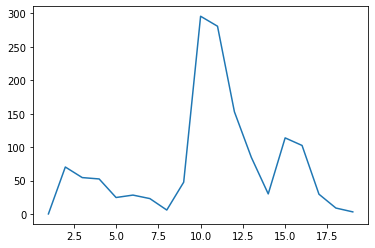

In [36]:
dt = [x[0] for x in model0q.tolist()]
plt.plot(range(1,n+1),dt)
plt.show()

# Compute posterior samples

In [ ]:
# Instantiate linear reservoir statistical model
lrm = LinearReservoirModel(nr,true_args)

@as_op(itypes=[tt.dscalar], otypes=[tt.dmatrix])
def th_forward_model(param1):
    parameter_list = [param1]

    th_states = lrm.simulate(parameter_list)
    return th_states

# Initialise dataframe to store parameter posteriors
keys = ['current_model','true_model','parameter','log_marginal_likelihood','mean', 'sd', 'mc_error', 'hpd_2.5', 'hpd_97.5']
results = pd.DataFrame(columns=keys)

# Initialise empty model and trace dictionaries
models = {}
traces = {}

# Loop over simulated datasets and compute marginal
for mi in tqdm(model_discharges.keys()):

    print(f'LRM posterior sample generation using {mi} data')

    with pm.Model() as LR_model:

        # Priors for unknown model parameters
        k = pm.Uniform('k', lower=0.01, upper=args.kmax)

        # Priors for initial conditions and noise level
        sigma = pm.Gamma('sigma',alpha=args.alpha,beta=args.beta)

        # Compute forward model
        forward = th_forward_model(k)
        
        # tt.printing.Print('Q_obs')(forward)

        # Compute likelihood
        Q_obs = pm.Normal('Q_obs', mu=forward, sigma=sigma, observed=model_discharges[mi])

        # Fix random seed
        np.random.seed(args.randomseed)

        # Initial points for each of the chains
        startsmc = [{'k':np.random.uniform(0.01,args.kmax,1)} for _ in range(args.nchains)]

        # Sample posterior
        trace_LR = pm.sample(args.nsamples, progressbar=True, chains=args.nchains, start=startsmc, step=pm.SMC())

        # Compute negative log marginal likelihood
        log_ml = -np.log(LR_model.marginal_likelihood)

        # Append to results
        vals = np.append(np.array(['LRM',mi,'k',log_ml]),pm.summary(trace_LR, ['k']).values[0])
        results = results.append(dict(zip(keys, vals)),ignore_index=True)
        vals = np.append(np.array(['LRM',mi,'sigma',log_ml]),pm.summary(trace_LR, ['sigma']).values[0])
        results = results.append(dict(zip(keys, vals)),ignore_index=True)

        # Append to models and traces
        models[mi] = LR_model
        traces[mi] = trace_LR

  0%|          | 0/3 [00:00<?, ?it/s]

LRM posterior sample generation using LRM data


Sample initial stage: ...
Stage: 0 Beta: 0.000 Steps: 25
Stage: 1 Beta: 0.000 Steps: 5
Stage: 2 Beta: 0.000 Steps: 3
Stage: 3 Beta: 0.000 Steps: 4
Stage: 4 Beta: 0.000 Steps: 4
Stage: 5 Beta: 0.000 Steps: 4
Stage: 6 Beta: 0.000 Steps: 5
Stage: 7 Beta: 0.000 Steps: 4


In [ ]:
results = results.set_index(['current_model','true_model','parameter'])

In [ ]:
print(json.dumps(true_params,indent=2))

In [ ]:
results

# Export data

In [ ]:
# Save results as csv
results.to_csv(os.path.join(rd,'data','output',args.output_filename.replace('.pickle','_summary.csv')), index = False)

In [ ]:
# Export models
for mi in tqdm(models.keys()):
    # Save model as pickle
    with open(os.path.join(rd,'data','output',args.output_filename.replace('.pickle',f'_{mi}data_model.pickle')), 'wb') as buff1:
        pickle.dump(models[mi], buff1)

In [ ]:
# Export traces
for mi in tqdm(traces.keys()):
    # Save trace as pickle
    with open(os.path.join(rd,'data','output',args.output_filename.replace('.pickle',f'_{mi}data_trace.pickle')), 'wb') as buff2:
        pickle.dump(traces[mi], buff2)

In [ ]:
print('Posterior computed and saved to...')
print(os.path.join(rd,'data','output',args.output_filename.replace('.pickle','')))

# Plot

In [ ]:
pm.traceplot(trace_LR);

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))
ppc_0 = pm.sample_posterior_predictive(trace_LR, 100, LR_model, size=(len(q), 20))
for m_0 in ppc_0['Q_obs'].T:
    pm.kdeplot(np.mean(m_0, 0), ax=ax, plot_kwargs={'color':'C0'})
ax.plot([], label='Linear Reservoir Model')
ax.legend(fontsize=14)
ax.set_xlabel(u'θ', fontsize=14)
ax.set_yticks([]);